# 🏀 March Madness Upset Prediction Model
### FDS II Final Project
##### Archie Korale Arachchige Don: abk844
##### Andres Navarrete: ann2339


This block sets up all the necessary libraries for the March Madness upset prediction project. It includes tools for:

- **Data manipulation**: Loading and processing datasets.
- **Model training and tuning**: Creating and optimizing machine learning models.
- **Evaluation metrics**: Assessing model performance using metrics like AUC and confusion matrix.
- **Data cleaning**: Handling missing values with imputation.
- **Balancing classes**: Using SMOTE to address class imbalance between upsets and non-upsets.
- **Visualization**: Creating plots to interpret data and model predictions.

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


Here we clean the matchup data

- **Loading the dataset** from a CSV file.
- **Cleaning**: Removes rows where either team's score is missing.
- **Label creation**:
  - `actual_winner`: Indicates if Team 1 won the game.
  - `is_upset`: Flags games as upsets when Team 1 wins despite having a worse seed.
- **Feature engineering**:
  - Computes differences between the two teams for various stats, such as:
    - Seed
    - Team ratings (TR, KenPom, Barthag)
    - Field goal performance (2s and 3s)
    - Public pick percentages

In [8]:
# Load the dataset
df = pd.read_csv("full_matchups.csv")

# Drop rows with missing label values
df = df.dropna(subset=["SCORE_1", "SCORE_2"])

# Create labels
df["actual_winner"] = df.apply(lambda row: 1 if row["SCORE_1"] > row["SCORE_2"] else 0, axis=1)
df["is_upset"] = df.apply(lambda row: 1 if row["actual_winner"] == 1 and row["SEED_1"] > row["SEED_2"] else 0, axis=1)

# Feature engineering
df["SEED_DIFF"] = df["SEED_1"] - df["SEED_2"]
df["TR_DIFF"] = df["TR_RATING_1"] - df["TR_RATING_2"]
df["KP_NET_DIFF"] = df["KP_NET_1"] - df["KP_NET_2"]
df["BARTHAG_DIFF"] = df["BARTHAG_1"] - df["BARTHAG_2"]
df["FG2_DIFF"] = df["CLOSE_TWOS_FG_1"] - df["CLOSE_TWOS_FG_2"]
df["FG3_DIFF"] = df["THREES_FG_1"] - df["THREES_FG_2"]
df["PICKED_DIFF"] = df["PICKED_1"].fillna(0) - df["PICKED_2"].fillna(0)


/var/folders/t0/nd29bp4n6v92r43y4r0s65xw0000gn/T/ipykernel_40885/2263507331.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["PICKED_DIFF"] = df["PICKED_1"].fillna(0) - df["PICKED_2"].fillna(0)


In [9]:
df.head()

,YEAR,game_id,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM_1,SEED_1,ROUND,CURRENT ROUND,SCORE_1,...,KP_NET_2,BARTHAG_2,actual_winner,is_upset,TR_DIFF,KP_NET_DIFF,BARTHAG_DIFF,FG2_DIFF,FG3_DIFF,PICKED_DIFF
0,2008,1,126,1136,31,North Carolina,1,4,64,113.0,...,-1.04085,0.448,1,0,24.5,29.18545,0.509,NaN,NaN,0
1,2008,2,121,1131,48,George Mason,12,64,64,50.0,...,7.30673,0.709,1,0,-0.3,2.97137,0.051,NaN,NaN,0
2,2008,3,117,1127,23,Saint Joseph's,11,64,64,64.0,...,4.12039,0.598,1,0,6.0,10.44541,0.235,NaN,NaN,0
3,2008,4,113,1123,19,South Alabama,10,64,64,61.0,...,1.68600,0.514,1,0,8.2,10.93790,0.281,NaN,NaN,0
4,2008,5,109,1119,25,Portland St.,16,64,64,61.0,...,13.82740,0.809,1,1,-4.2,-7.99075,-0.213,NaN,NaN,0


In [10]:
df.tail()

,YEAR,game_id,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM_1,SEED_1,ROUND,CURRENT ROUND,SCORE_1,...,KP_NET_2,BARTHAG_2,actual_winner,is_upset,TR_DIFF,KP_NET_DIFF,BARTHAG_DIFF,FG2_DIFF,FG3_DIFF,PICKED_DIFF
250,2024,12,1970,2050,1061,Florida,7,64,64,100.0,...,3.06263,0.593,1,0,11.6,15.12577,0.302,1.2,-0.2,0
251,2024,13,1965,2045,1058,Grambling St.,16,64,64,50.0,...,17.29230,0.869,0,0,-21.6,-25.10229,-0.588,-4.3,-1.5,0
252,2024,14,1961,2041,1046,McNeese St.,12,64,64,65.0,...,9.79228,0.732,0,0,0.0,3.07032,0.020,-2.2,0.1,0
253,2024,15,1958,2038,1028,South Carolina,6,64,64,73.0,...,4.93709,0.596,1,0,5.3,10.12611,0.246,-3.4,1.5,0
254,2024,16,1953,2033,1068,Colorado St.,10,64,64,44.0,...,-2.32142,0.404,0,0,13.4,18.92412,0.442,18.6,-0.7,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 0 to 254
Data columns (total 50 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YEAR             255 non-null    int64  
 1   game_id          255 non-null    int64  
 2   BY YEAR NO       255 non-null    int64  
 3   BY ROUND NO      255 non-null    int64  
 4   TEAM NO          255 non-null    int64  
 5   TEAM_1           255 non-null    object 
 6   SEED_1           255 non-null    int64  
 7   ROUND            255 non-null    int64  
 8   CURRENT ROUND    255 non-null    int64  
 9   SCORE_1          255 non-null    float64
 10  BY YEAR NO_2     255 non-null    int64  
 11  BY ROUND NO_2    255 non-null    int64  
 12  TEAM NO_2        255 non-null    int64  
 13  TEAM_2           255 non-null    object 
 14  SEED_2           255 non-null    int64  
 15  ROUND_2          255 non-null    int64  
 16  CURRENT ROUND_2  255 non-null    int64  
 17  SCORE_2          255 

More prep for modeling by:

- **Defining features and labels**:
  - `X`: Input features such as seed difference, ratings, and shooting stats.
  - `y`: Target label indicating whether the game was an upset.
  
- **Splitting the data**:
  - Divides the dataset into training and testing sets (75% / 25% split).

- **Handling missing values**:
  - Uses mean imputation to fill in any missing feature values.

- **Balancing the classes**:
  - Applies SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples of upsets and address class imbalance.

In [12]:
# Define features and labels
features = ["SEED_DIFF", "TR_DIFF", "KP_NET_DIFF", "BARTHAG_DIFF", "FG2_DIFF", "FG3_DIFF", "PICKED_DIFF"]
X = df[features]
y = df["is_upset"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_imputed, y_train)


#### Random Forest Model Training & Evaluation

This section builds and evaluates a Random Forest classifier:

- **Hyperparameter tuning**:
  - Uses `GridSearchCV` to test different combinations of:
    - Number of trees (`n_estimators`)
    - Maximum depth of trees (`max_depth`)
    - Minimum samples required to split a node (`min_samples_split`)
  - Performs 3-fold cross-validation using F1-score as the scoring metric.
  - Uses `class_weight="balanced"` to adjust for class imbalance.

- **Model selection**:
  - Selects the best-performing model based on grid search results.

- **Evaluation on test data**:
  - Generates predictions and evaluates them using:
    - Confusion matrix
    - Classification report (precision, recall, f1-score)
    - ROC AUC score


In [13]:
# Random Forest with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_resampled, y_resampled)
best_rf = grid_search.best_estimator_

# Evaluate
y_pred_rf = best_rf.predict(X_test_imputed)
print("Random Forest (Tuned) Evaluation")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("AUC Score:", roc_auc_score(y_test, best_rf.predict_proba(X_test_imputed)[:, 1]))


Random Forest (Tuned) Evaluation
[[47 10]
 [ 5  2]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        57
           1       0.17      0.29      0.21         7

    accuracy                           0.77        64
   macro avg       0.54      0.56      0.54        64
weighted avg       0.82      0.77      0.79        64

AUC Score: 0.7431077694235589


#### XGBoost Model Training & Evaluation

This section trains and evaluates an XGBoost classifier:

- **Model setup**:
  - `scale_pos_weight` is set based on the ratio of non-upsets to upsets to handle class imbalance.
  - `eval_metric` is set to "logloss" to track model performance.
  - `use_label_encoder=False` avoids deprecated label encoding behavior.

- **Training**:
  - Fits the model on the resampled training data (from SMOTE).

- **Evaluation on test data**:
  - Predicts outcomes on the test set.
  - Outputs performance using:
    - Confusion matrix
    - Classification report (precision, recall, f1-score)
    - ROC AUC score


In [14]:
from xgboost import XGBClassifier

# XGBoost with scale_pos_weight
class_ratio = y_resampled.value_counts()[0] / y_resampled.value_counts()[1]
xgb = XGBClassifier(scale_pos_weight=class_ratio, eval_metric="logloss", use_label_encoder=False)
xgb.fit(X_resampled, y_resampled)

# Evaluate
y_pred_xgb = xgb.predict(X_test_imputed)
print("XGBoost Evaluation")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("AUC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test_imputed)[:, 1]))


XGBoost Evaluation
[[46 11]
 [ 5  2]]
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        57
           1       0.15      0.29      0.20         7

    accuracy                           0.75        64
   macro avg       0.53      0.55      0.53        64
weighted avg       0.82      0.75      0.78        64

AUC Score: 0.7167919799498746


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Predicted Upset Probability Distribution

This section analyzes the model’s predicted probabilities for upsets:

- **Create a results DataFrame**:
  - Stores test set features, true labels, and predicted probabilities of an upset from the Random Forest model.

- **Plot a histogram**:
  - Visualizes the distribution of predicted upset probabilities.
  - Differentiates actual upsets vs. non-upsets using color (`hue="true_label"`).
  - Includes kernel density estimation (`kde=True`) for smooth curves.
  - Helps interpret model confidence — whether predictions cluster near 0 (non-upsets) or near 1 (upsets).

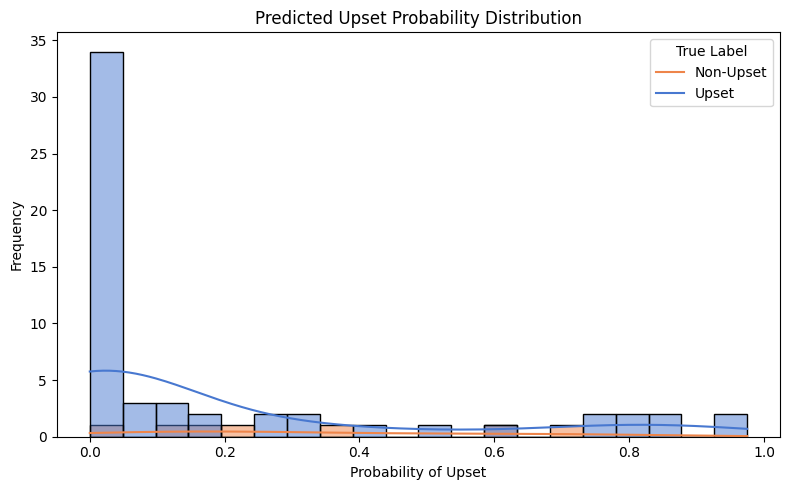

In [15]:
# Predict probabilities from the best random forest model
results_df = pd.DataFrame(X_test_imputed, columns=features)
results_df["true_label"] = y_test.values
results_df["upset_probability"] = best_rf.predict_proba(X_test_imputed)[:, 1]

# Histogram of upset probabilities by true class
plt.figure(figsize=(8, 5))
sns.histplot(data=results_df, x="upset_probability", hue="true_label", bins=20, kde=True, palette="muted")
plt.title("Predicted Upset Probability Distribution")
plt.xlabel("Probability of Upset")
plt.ylabel("Frequency")
plt.legend(title="True Label", labels=["Non-Upset", "Upset"])
plt.tight_layout()
plt.show()


#### Graph Observations

1. **Majority of Predictions Near 0**  
   - Most predicted probabilities fall between **0.0 and 0.1**, indicating the model is highly confident that most games are **not upsets**.
   - This is expected since non-upsets are more common in the dataset.

2. **Actual Upsets Predicted Poorly**  
   - Some actual upsets (blue bars) also appear in the low-probability range, meaning the model **missed** them.
   - This shows the difficulty in identifying rare events like upsets.

3. **Increased Spread at Higher Probabilities**  
   - Predictions become more mixed (both upsets and non-upsets) as probability increases from **0.4 to 1.0**.
   - This indicates the model is **less certain** and occasionally takes risks.

4. **Upset Density Curve Insight**  
   - The blue KDE line (density curve) shows the model **sometimes assigns higher probabilities** to real upsets — but not consistently.

### Overall Interpretation

- The model is **conservative**, mostly predicting low upset probabilities.
- It performs better at spotting **non-upsets** than identifying true **upsets**.
- This graph highlights the **challenge of class imbalance** and the need for:
  - **SMOTE** for balancing training data
  - **Threshold tuning** to improve sensitivity to upsets
---

### Top 10 Most Likely Upsets Predicted by Model

This block identifies and visualizes the games with the highest predicted probabilities of an upset:

- **Sort and select**:
  - Sorts the test set predictions (`results_df`) by the `upset_probability` in descending order.
  - Selects the **top 10 games** with the highest predicted likelihood of an upset.

- **Visualize**:
  - Creates a horizontal bar plot using Seaborn to display upset probabilities.
  - X-axis: Predicted upset probability
  - Y-axis: Matchup index (row number from the test set)
  - Colors: Uses the `viridis` palette for visual appeal.

- **Output table**:
  - Displays the `upset_probability` and the actual `true_label` (0 = non-upset, 1 = upset) for these top 10 games.

### Purpose:
This helps identify:
- Games the model is **most confident** are upsets.
- Whether those predictions were actually correct (via `true_label`).
- Potential value in reviewing or analyzing these high-risk matchups further.

/var/folders/t0/nd29bp4n6v92r43y4r0s65xw0000gn/T/ipykernel_40885/4053757589.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


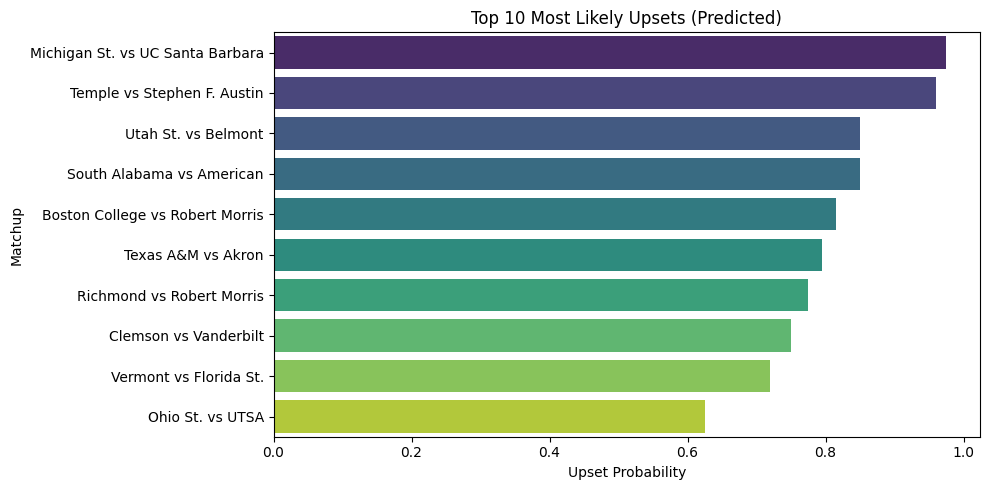

,matchup,upset_probability,true_label
63,Michigan St. vs UC Santa Barbara,0.975,0
30,Temple vs Stephen F. Austin,0.960,0
61,Utah St. vs Belmont,0.850,0
3,South Alabama vs American,0.850,0
19,Boston College vs Robert Morris,0.815,0
59,Texas A&M vs Akron,0.795,0
47,Richmond vs Robert Morris,0.775,0
5,Clemson vs Vanderbilt,0.750,0
36,Vermont vs Florida St.,0.720,1
48,Ohio St. vs UTSA,0.625,1


In [16]:
# Add matchup labels using team names
results_df["matchup"] = df.loc[results_df.index, "TEAM_1"] + " vs " + df.loc[results_df.index, "TEAM_2"]

# Sort and plot top predicted upsets
top_upsets = results_df.sort_values(by="upset_probability", ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_upsets["upset_probability"],
    y=top_upsets["matchup"],  # Use team names for labels
    palette="viridis"
)
plt.title("Top 10 Most Likely Upsets (Predicted)")
plt.xlabel("Upset Probability")
plt.ylabel("Matchup")
plt.tight_layout()
plt.show()

# View table with matchups and predictions
top_upsets[["matchup", "upset_probability", "true_label"]]


### What the Graph Shows:
This horizontal bar chart displays the 10 games where the **Random Forest model** assigned the **highest probabilities** of an upset occurring.

- **Y-axis (Matchup)**: Each bar represents a game, labeled with the two competing teams.
- **X-axis (Upset Probability)**: Indicates how confident the model is that the lower-seeded team would beat the higher-seeded one.

###  Key Insights:

1. **High Confidence Predictions**:
   - The top two matchups (`Michigan St. vs UC Santa Barbara`, `Temple vs Stephen F. Austin`) received **very high probabilities (~0.95–0.98)**.
   - This suggests the model saw strong statistical signals favoring a potential upset.

2. **Tight Probability Range**:
   - All 10 matchups have upset probabilities ranging roughly from **0.60 to 0.98**, indicating **moderate to high confidence** in these games being upsets.

3. **Potential Model Utility**:
   - Even if not all of these games were actual upsets, this list is valuable for:
     - Identifying **high-risk matchups**
     - **Bracketing strategy** for fans and analysts
     - Understanding how the model interprets feature combinations

### Interpretation:
This chart provides a **snapshot of the model’s boldest predictions**, highlighting the matchups where:
- Public pick rates, team ratings, and other stats strongly favored the underdog.
- The model may be **taking more risk** in pursuit of rare but meaningful predictions.

---

### Feature Importances (Random Forest)

This block visualizes how much each input feature contributed to the predictions made by the **tuned Random Forest model**:

- **Extract feature importances**:
  - Retrieves the learned importance scores for each feature from the `best_rf` model.
  - Higher scores indicate greater influence on the model's decision-making.

- **Create a sorted series**:
  - Converts the importances into a Pandas Series with feature names as the index.
  - Sorts the series in ascending order to improve readability in the plot.

- **Generate a horizontal bar plot**:
  - Displays the importance scores for all features.
  - Helps identify which features were most predictive (e.g., `SEED_DIFF`, `TR_DIFF`).

### Purpose:
This plot supports **model interpretability** by showing which variables were most useful in predicting upsets.

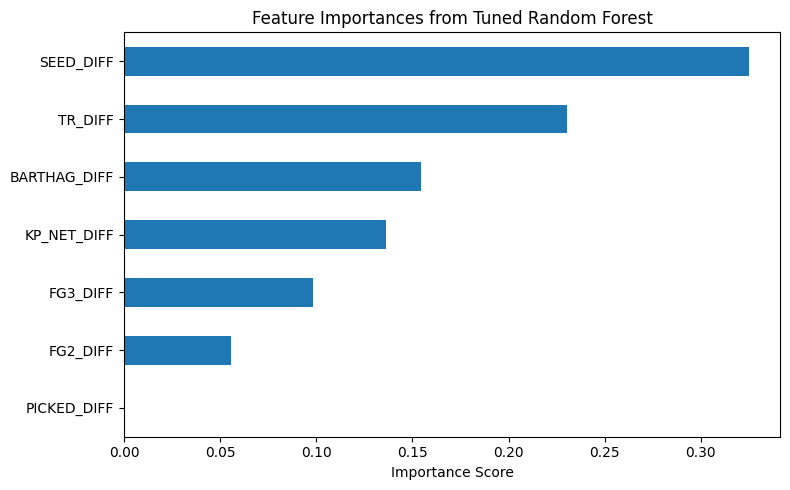

In [17]:
importances = best_rf.feature_importances_
feat_series = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
feat_series.plot(kind='barh')
plt.title("Feature Importances from Tuned Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


### Confusion Matrix (Random Forest)

This block visualizes the performance of the tuned **Random Forest model** using a confusion matrix:

- **Create the matrix**:
  - Uses `ConfusionMatrixDisplay.from_estimator()` to generate the matrix directly from the model.
  - Compares the model's predictions (`X_test_imputed`) with the true labels (`y_test`).

- **Customize display**:
  - Labels the classes as `"Non-Upset"` and `"Upset"` for easier interpretation.
  - Applies the `"Blues"` color map for visual clarity.

- **Show the plot**:
  - Displays a heatmap-style grid showing the counts of:
    - **True Negatives (TN)**: Correctly predicted non-upsets
    - **False Positives (FP)**: Incorrectly predicted upsets
    - **False Negatives (FN)**: Missed actual upsets
    - **True Positives (TP)**: Correctly predicted upsets

### Purpose:
The confusion matrix helps evaluate where the model is performing well or struggling — especially important for detecting rare events like upsets.

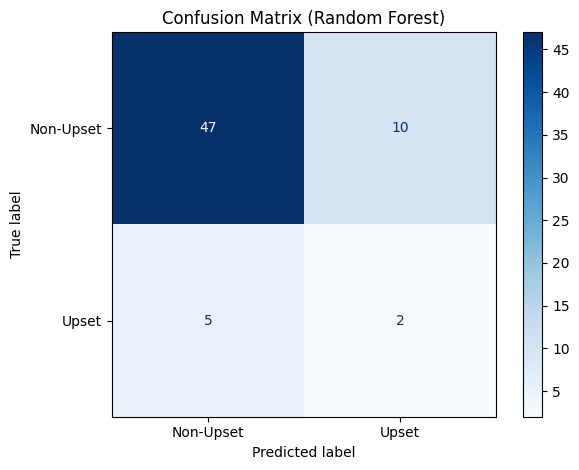

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_rf, X_test_imputed, y_test, display_labels=["Non-Upset", "Upset"], cmap="Blues")
plt.title("Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()


### Threshold Tuning to Improve Upset Detection

This block explores how changing the **classification threshold** affects the model’s performance in predicting upsets:

- **Generate probabilities**:
  - Uses the `predict_proba()` method from the tuned Random Forest model to get the predicted probabilities of an upset for each test instance.

- **Compute precision and recall**:
  - Uses `precision_recall_curve()` to calculate precision and recall at various probability thresholds.

- **Plot the trade-off**:
  - Plots **precision** and **recall** as lines against the **classification threshold**.
  - Helps visualize how increasing the threshold (being more confident before calling an upset) improves precision but usually reduces recall — and vice versa.

### Purpose:
This plot helps choose an **optimal probability threshold** depending on whether you want the model to:
- Be **more precise** (fewer false positives), or
- Be **more sensitive** (catch more true upsets).

Useful when the cost of **missing an upset** is different from **falsely predicting one**.


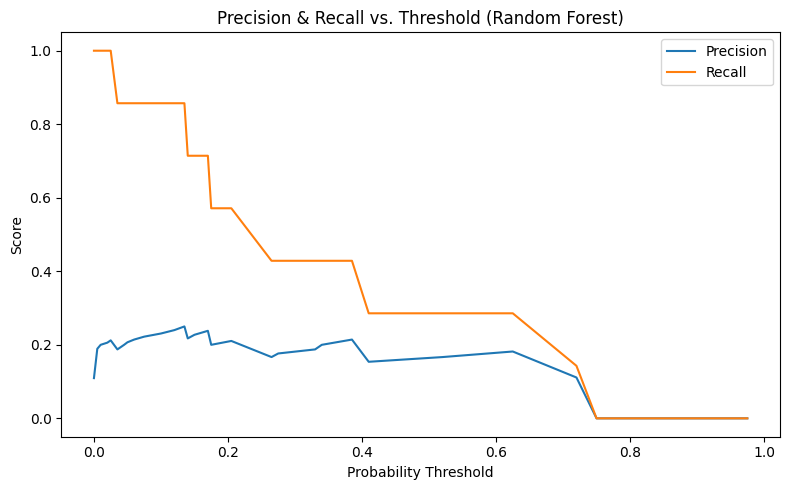

In [19]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities for test set
probs_rf = best_rf.predict_proba(X_test_imputed)[:, 1]

# Calculate precision-recall at different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, probs_rf)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs. Threshold (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()


This line plot visualizes how the **precision** and **recall** of the Random Forest model change as you adjust the **probability threshold** for classifying an upset.

- **X-axis**: Probability threshold (0.0 to 1.0) — the minimum probability the model must assign for a game to be labeled as an upset.
- **Y-axis**: Score — values for precision (blue line) and recall (orange line).

### Key Insights:

1. **Recall starts high, drops sharply**:
   - At very low thresholds (close to 0.0), the model predicts almost every game as an upset, capturing **almost all true upsets** (high recall).
   - As the threshold increases, the model becomes **more conservative**, and recall drops quickly — meaning it **misses more actual upsets**.

2. **Precision is consistently low**:
   - Across all thresholds, precision remains below ~0.3, meaning that when the model predicts an upset, it’s **often wrong**.
   - This suggests a **high false positive rate**, which is common in imbalanced datasets.

3. **Trade-off zone**:
   - Around threshold values of **0.2–0.4**, recall and precision stabilize into a **more balanced (but still imperfect)** region.
   - This might be a good candidate range for setting a custom threshold depending on whether **catching more upsets** (higher recall) or **avoiding false alarms** (higher precision) is more important.

###  Interpretation:
- **Lower thresholds** = model is aggressive, finds more true upsets, but also more false alarms.
- **Higher thresholds** = model is cautious, but risks **missing upsets entirely**.
- A carefully chosen threshold (e.g., 0.4 used in the ensemble) can help balance performance for practical use.

This graph is crucial for **threshold tuning** and helps guide decision-making depending on whether your goal is to:
- Maximize upset detection (favor recall)
- Minimize false calls (favor precision)
---

### Feature Engineering Enhancements

This block introduces **new features** to improve the model’s ability to detect upsets and re-prepares the dataset:

### Added Features:
- `SEED_DIFF_SQ`: The square of the seed difference — captures non-linear effects.
- `SEED_DIFF_LOG`: Logarithmic scale of seed difference magnitude — stabilizes extreme values.
- `RATING_INTERACTION`: Interaction between TR and KP ratings — highlights combined effects.
- `PUBLIC_ABS_DIFF`: Absolute difference in public pick percentages — measures disagreement in public opinion.

### Updated Workflow:
- Updates the feature list to include the new engineered features.
- Re-splits the dataset into training and testing sets.
- Re-applies:
  - **Mean imputation** for missing values.
  - **SMOTE** to balance the training data.

### Purpose:
By introducing richer and more complex variables, this step aims to improve model learning and better capture nuanced patterns in the data — especially important for detecting rare events like upsets.

In [20]:
# Add new transformed and interaction features
df["SEED_DIFF_SQ"] = df["SEED_DIFF"] ** 2
df["SEED_DIFF_LOG"] = np.log1p(df["SEED_DIFF"].abs())
df["RATING_INTERACTION"] = df["TR_DIFF"] * df["KP_NET_DIFF"]
df["PUBLIC_ABS_DIFF"] = df["PICKED_DIFF"].abs()

# Update features list
features_enhanced = features + ["SEED_DIFF_SQ", "SEED_DIFF_LOG", "RATING_INTERACTION", "PUBLIC_ABS_DIFF"]

# Re-split and reprocess with new features
X = df[features_enhanced]
y = df["is_upset"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_imputed, y_train)


### Ensemble Model: Random Forest + XGBoost

This block combines predictions from two different models to improve upset detection:

### Model Training:
- **Random Forest (`rf_ensemble`)**:
  - Re-trained on the enhanced, SMOTE-balanced dataset.
  - Uses 100 estimators and balanced class weights.

- **XGBoost (`xgb_ensemble`)**:
  - Also trained on the same dataset.
  - Uses class ratio-based `scale_pos_weight` to handle imbalance.
  - Evaluates with `"logloss"` and disables deprecated label encoding.

###  Ensemble Prediction:
- Calculates the **average predicted probability** of an upset from both models.
- Applies a **custom classification threshold of 0.4** to generate final binary predictions.

###  Evaluation:
- Outputs:
  - Confusion matrix
  - Classification report (precision, recall, f1-score)
  - ROC AUC score for the combined model

###  Purpose:
This ensemble strategy leverages the strengths of both models. By averaging their predictions, the ensemble aims to:
- Improve predictive stability
- Enhance sensitivity to true upsets
- Balance precision and recall more effectively than either model alone

In [21]:
# Re-train Random Forest on resampled data
rf_ensemble = RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=100)
rf_ensemble.fit(X_resampled, y_resampled)

# Retrain XGBoost on same data
from xgboost import XGBClassifier
class_ratio = y_resampled.value_counts()[0] / y_resampled.value_counts()[1]
xgb_ensemble = XGBClassifier(scale_pos_weight=class_ratio, eval_metric="logloss", use_label_encoder=False)
xgb_ensemble.fit(X_resampled, y_resampled)

# Ensemble prediction: average probabilities
probs_rf = rf_ensemble.predict_proba(X_test_imputed)[:, 1]
probs_xgb = xgb_ensemble.predict_proba(X_test_imputed)[:, 1]
ensemble_probs = (probs_rf + probs_xgb) / 2

# Apply threshold and evaluate
y_pred_ensemble = (ensemble_probs > 0.4).astype(int)

print("Confusion Matrix (Ensemble @ 0.4 Threshold)")
print(confusion_matrix(y_test, y_pred_ensemble))
print(classification_report(y_test, y_pred_ensemble))
print("AUC Score:", roc_auc_score(y_test, ensemble_probs))


Confusion Matrix (Ensemble @ 0.4 Threshold)
[[45 12]
 [ 5  2]]
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        57
           1       0.14      0.29      0.19         7

    accuracy                           0.73        64
   macro avg       0.52      0.54      0.52        64
weighted avg       0.82      0.73      0.77        64

AUC Score: 0.7493734335839599


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:44:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
